In [16]:
import pandas as pd
import numpy as np
import scipy as sp

import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

import operator as op

from tqdm import tqdm_notebook, tnrange

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [17]:
np.random.seed(42)

In [18]:
sns.set()
sns.set_context("notebook", font_scale=2)

In [19]:
burst_oscore_cols = [ 'burst_oscore_12.0_20.0', 'burst_oscore_20.0_30.0',
       'burst_oscore_3.0_8.0', 'burst_oscore_30.0_60.0',
       'burst_oscore_60.0_90.0', 'burst_oscore_8.0_12.0']

burst_params = [ ]

spiketrain_params = ['AI', 'burst_spike_percent', 'cv', 'firing_rate', 'frequency_variance', 'isi_mean', 'isi_median', 'isi_std',
                    'isi_larger_than_mean', 'kurtoisis', 'skewness', 'lv', 'nu', 
                     'oscore_12.0_20.0', 'oscore_20.0_30.0', 'oscore_3.0_8.0', 'oscore_30.0_60.0',
                     'oscore_60.0_90.0', 'oscore_8.0_12.0','interburst_interval', 'mean_burst_len', 'ratio_burst_time',
                    'mean_isi_in_burst', 'median_isi_in_burst', 'mean_spikes_in_burst']

recording_params = ['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length']
useless_params = ['burst_index',  'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio']

In [20]:
data_awake = pd.read_excel('awake.xls')
# data_awake = data_awake.drop(['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length',
#                              'burst_index',  'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)

data_awake = data_awake.rename(columns={'burst_mean':'AI', 'burst_percent':'isi_larger_than_mean'})
data_awake = data_awake[spiketrain_params + burst_params  + recording_params + ['patient']]

# for c in burst_oscore_cols:
#     data_awake = data_awake[data_awake[c] > 0.]
#     data_awake = data_awake.drop([c], axis=1)

# data_awake = data_awake.drop(burst_oscore_cols, axis=1)

data_awake = data_awake[(data_awake['mean_spikes_in_burst'] > 0) & (data_awake['mean_spikes_in_burst'] < 100)]
data_awake['mean_burst_len'] = data_awake['mean_burst_len'].astype(float)

In [21]:
data_sleep = pd.read_excel('sleep.xls')
# data_sleep = data_sleep.drop(['doc_name', 'data_name', 'interval_name', 'spike_count', 'filter_length',
#                              'burst_index', 'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio'], axis=1)

data_sleep = data_sleep.rename(columns={'burst_mean':'AI', 'burst_percent':'isi_larger_than_mean'})

data_sleep = data_sleep[spiketrain_params + burst_params + recording_params + ['patient']]

# for c in burst_oscore_cols:
#     data_sleep = data_sleep[data_sleep[c] > 0.]
#     data_sleep = data_sleep.drop([c], axis=1)

# data_sleep = data_sleep.drop(burst_oscore_cols, axis=1)

data_sleep = data_sleep[ (data_sleep['mean_spikes_in_burst'] > 0) & (data_sleep['mean_spikes_in_burst'] < 100)]
data_sleep['mean_burst_len'] = data_sleep['mean_burst_len'].astype(float)

In [22]:
data_sleep['awake'] = 0
data_awake['awake'] = 1

data = pd.concat([data_sleep, data_awake], ignore_index=True)

data = data[data['filter_length'] > 5]
data = data.drop(recording_params, axis=1)

patients = data['patient']
data = data.drop(['patient'], axis=1)

old_cols = list(data.columns.values)
data.columns = list(range(1, len(old_cols) + 1))

# spiketrain_idx = [old_cols.index(p) + 1 for p in spiketrain_params]
# burst_idx = [old_cols.index(p) + 1 for p in burst_params]

In [23]:
print(data.shape)

(339, 26)


In [24]:
data.columns.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [25]:
data.to_csv('without_burst_oscore.csv', index=False)
# data[spiketrain_idx + [data.columns.values[~0]]].to_csv('spiketrain_params.csv', index=False)
# data[burst_idx + [data.columns.values[~0]]].to_csv('burst_params.csv', index=False)

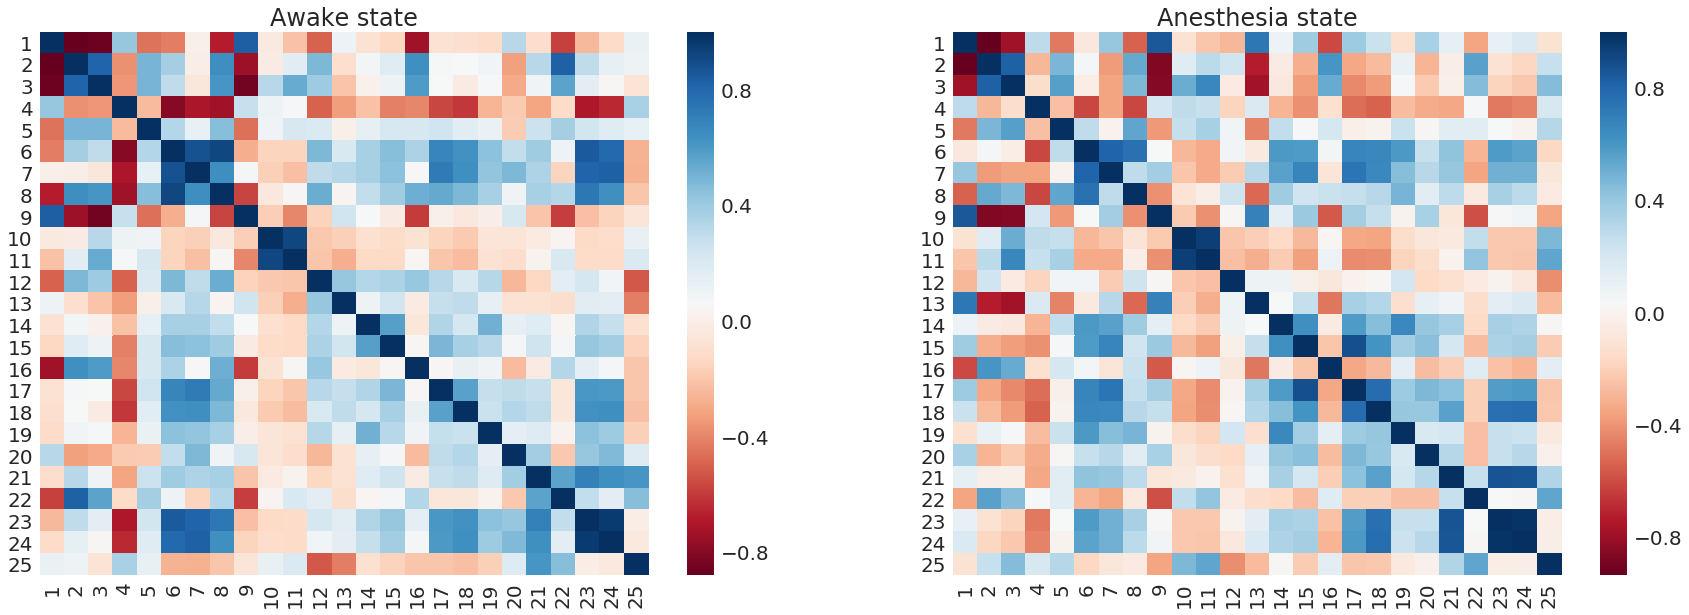

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(30,10))

awake_corr = data[data[old_cols.index('awake') + 1] == 1].drop(old_cols.index('awake') + 1, axis=1).corr()
sleep_corr = data[data[old_cols.index('awake') + 1] == 0].drop(old_cols.index('awake') + 1, axis=1).corr()

sns.heatmap(awake_corr, ax=ax1, cmap='RdBu')
sns.heatmap(sleep_corr, ax=ax2, cmap='RdBu')
ax1.set_title('Awake state')
ax2.set_title('Anesthesia state')

In [27]:
def simple_cv(X, y, patients, model_type, params=None, plot=True, ax=None):
    
    if model_type == 'xgb':
        model = xgb.XGBClassifier(**params)
    elif model_type == 'linear':
        model = LogisticRegression()
    elif model_type == 'rf':        
        model = RandomForestClassifier(**params)

    acc = np.mean(cross_val_score(Pipeline([('n', Normalizer()), ('m', model)]), X, y, scoring='accuracy', cv=5))
    probs = cross_val_predict(model, X, y, method='predict_proba', cv=5)[:,1]
    fpr, tpr, _ = roc_curve(y, probs)
    auc_score = auc(fpr, tpr)
    
    
    if plot:
        if ax is None:
            f, ax = plt.subplots(figsize=(15,10))
        
        ax.plot([0, 1], [0, 1], 'k--')
        ax.plot(fpr, tpr)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('CV by patients, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))

    return acc, auc_score

In [28]:
def patient_cv(X, y, patients, model_type, params=None, plot=True, ax=None):
    all_idx = np.array(range(X.shape[0]))
    
    names = set(patients)
    
    X = X.as_matrix()
    y = np.array(y)
        
    y_pred = np.zeros(y.shape[0], dtype=int)
    probs = np.zeros(y.shape[0], dtype=float)
    acc = list()
    
    for p in names:
        test_idx = np.where(patients == p)
        train_idx = np.delete(all_idx, test_idx, 0)
        
        X_train = X[train_idx]
        X_test = X[test_idx]
        
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        if model_type == 'xgb':
            m = xgb.XGBClassifier(**params)
        elif model_type == 'linear':
            m = LogisticRegression()
        elif model_type == 'rf':
            m = RandomForestClassifier(**params)
        
        model = Pipeline([('n', Normalizer()), ('m', m)])
        
        model.fit(X_train, y_train)
        
        curr_pred = model.predict(X_test)
        
        y_pred[test_idx] = curr_pred
        probs[test_idx] = model.predict_proba(X_test)[:,1]
        
        acc.append(accuracy_score(y_test, curr_pred))
        
    acc = accuracy_score(y, y_pred)
    fpr, tpr, _ = roc_curve(y, probs)
    auc_score = auc(fpr, tpr)
    
    if plot:
        if ax is None:
            f, ax = plt.subplots(figsize=(15,10))
        
        ax.plot([0, 1], [0, 1], 'k--')
        ax.plot(fpr, tpr)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('CV by patients, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))
    
    return acc, auc_score

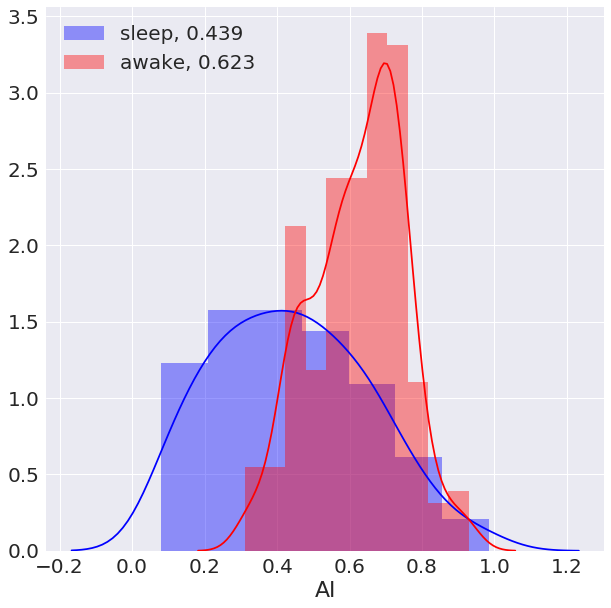

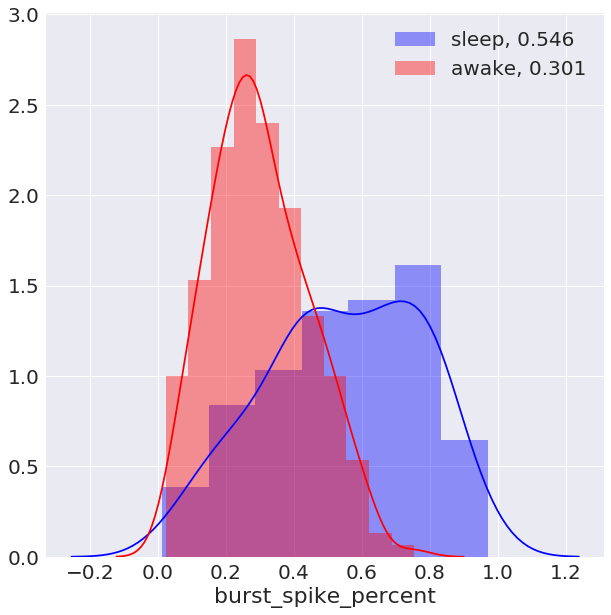

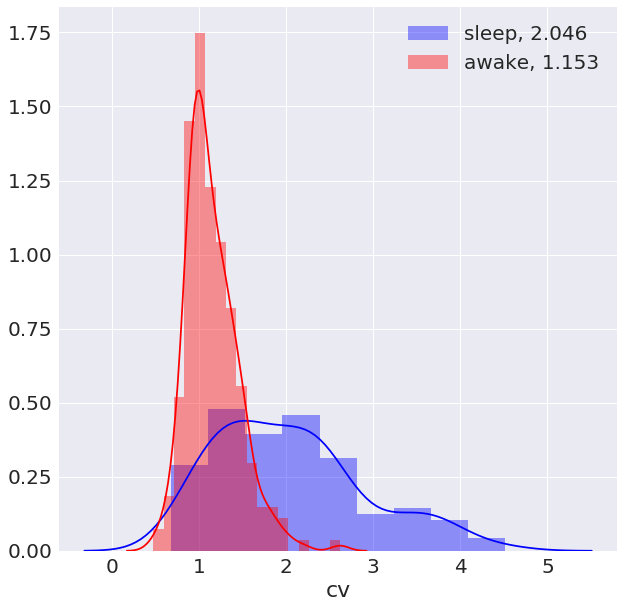

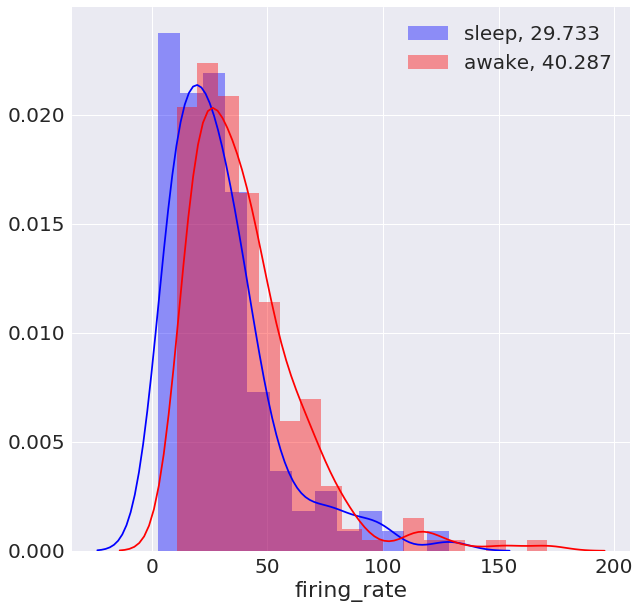

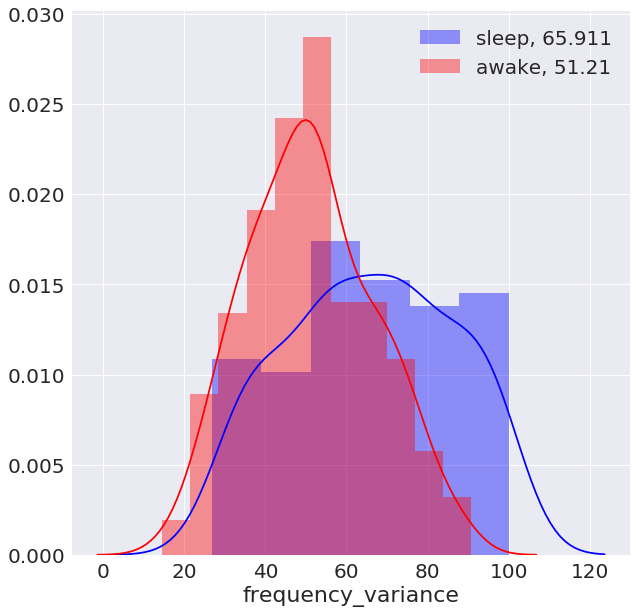

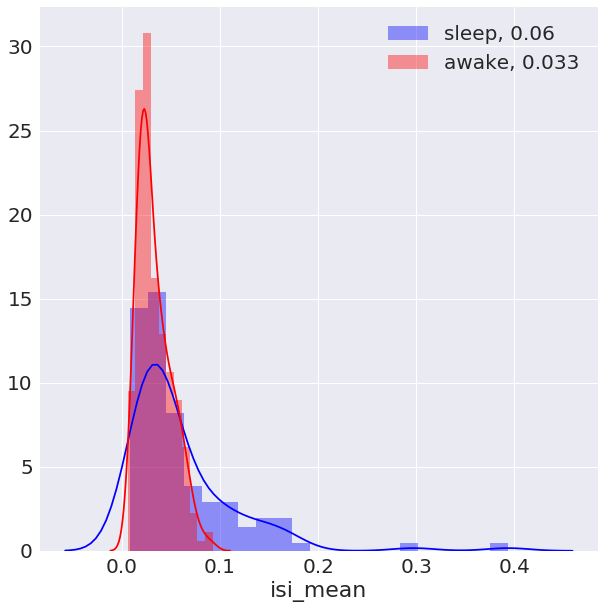

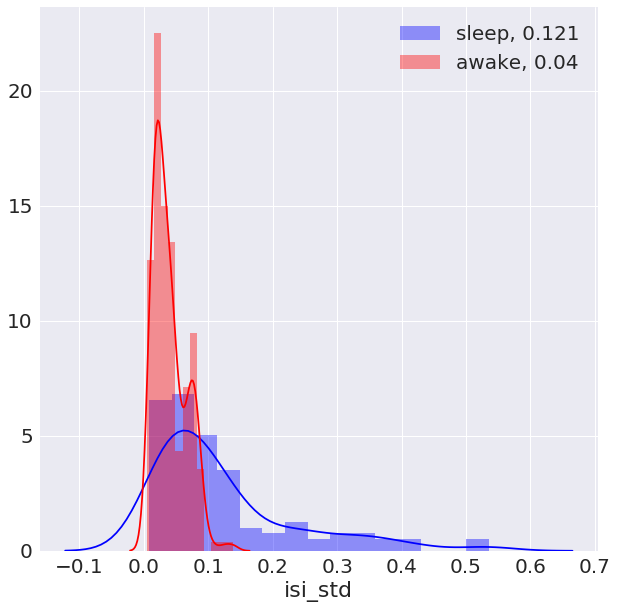

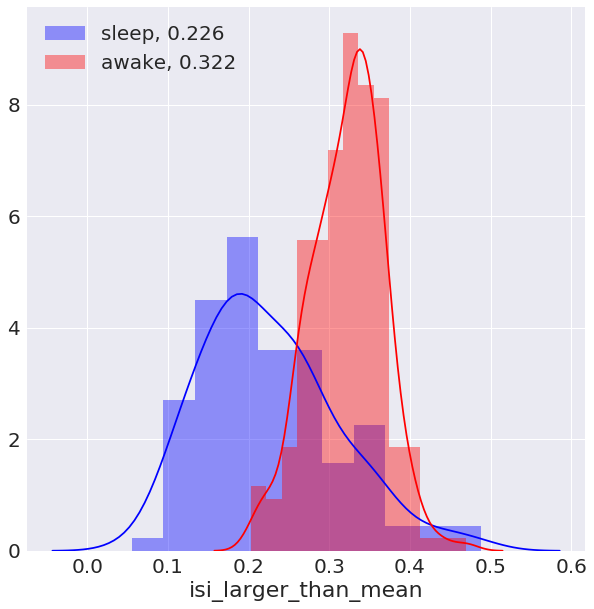

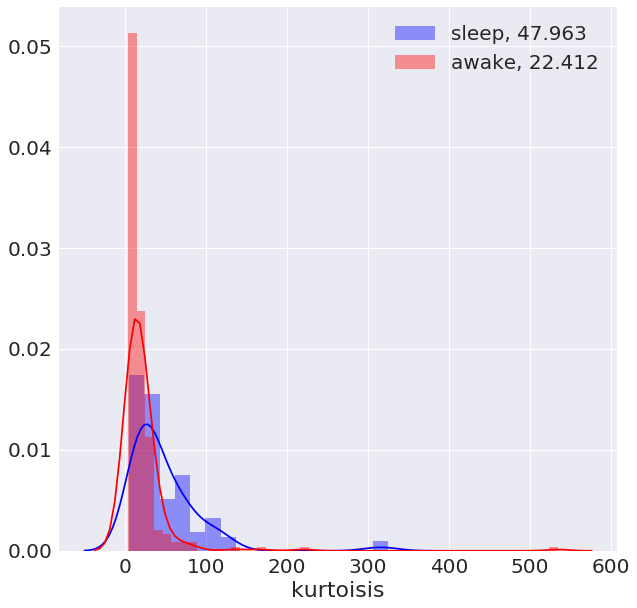

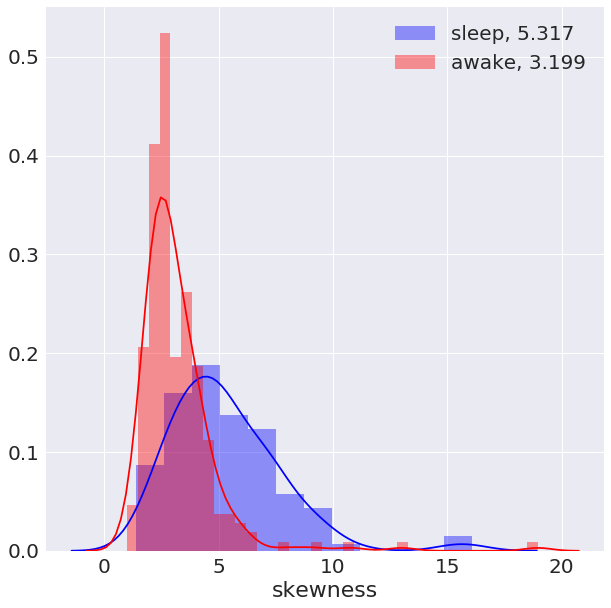

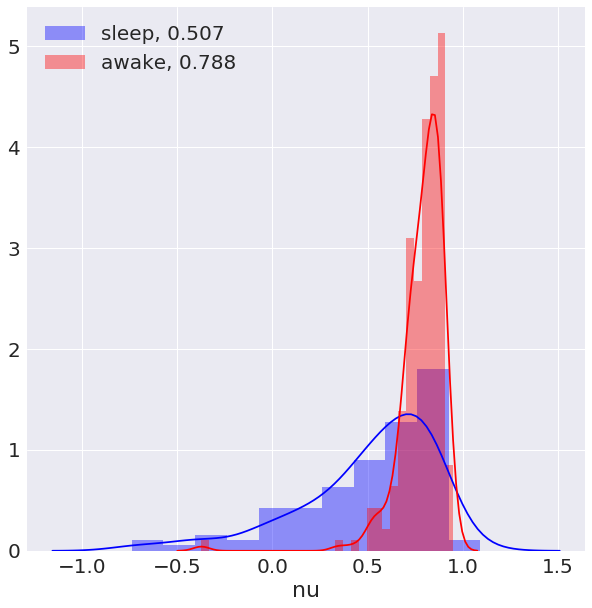

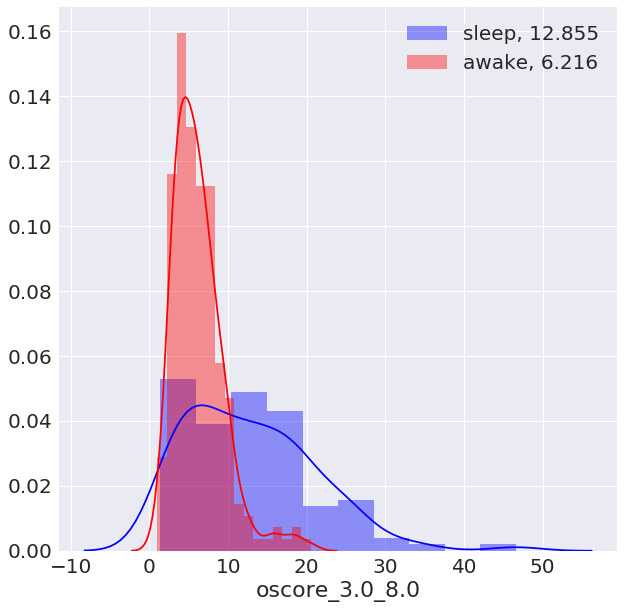

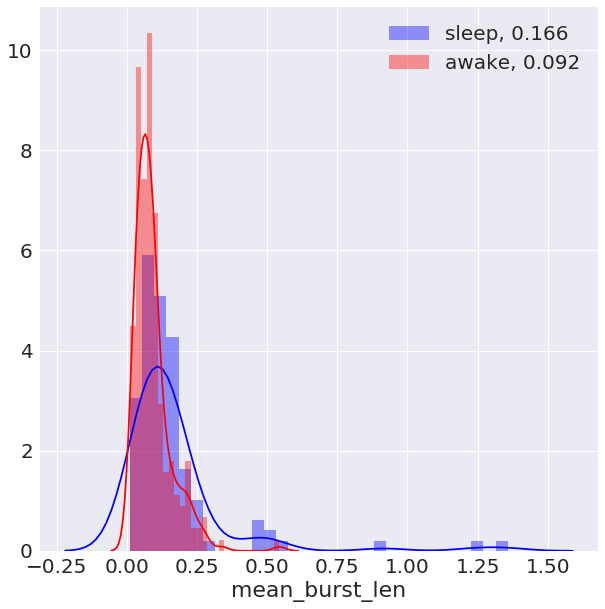

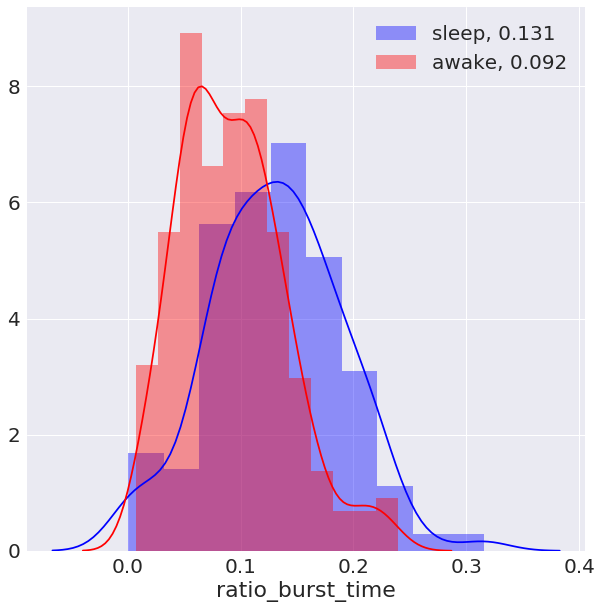

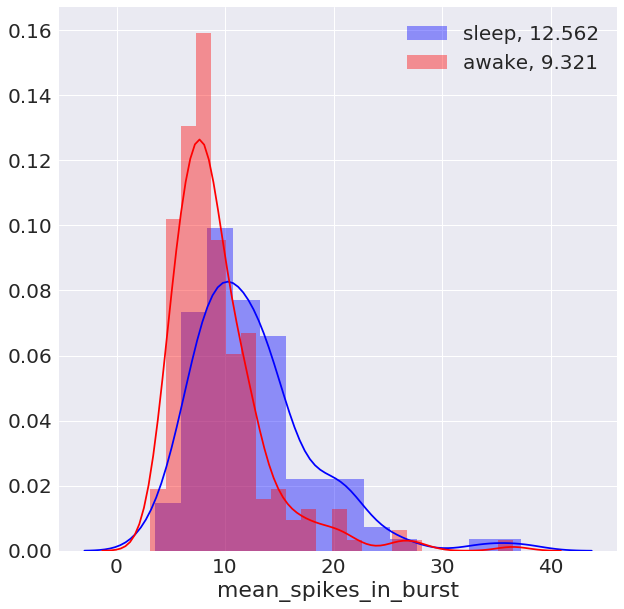

In [51]:
for c in data_sleep.drop(['awake'] + recording_params, axis=1).columns.values:
    sleep_data = data_sleep[c]
    awake_data = data_awake[c]

    stat, pval = sp.stats.mannwhitneyu(sleep_data, awake_data)
    if pval < 1e-5:
        plt.figure(figsize=(10,10))
        sns.distplot(sleep_data, color='blue', label='sleep, {}'.format(round(np.mean(sleep_data), 3)))
        sns.distplot(awake_data, color='red', label='awake, {}'.format(round(np.mean(awake_data), 3)))
        plt.legend()
        plt.autoscale()


In [30]:
def fix_params(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
#     params['max_features'] = int(params['max_features'])
    
    return params

def score(X, y, patients, pbar, cv_type, model_type, metric, params):
    params = fix_params(params)
    
    if cv_type == 'patient':
        accuracy, auc = patient_cv(X, y, patients, model_type, params, plot=False)
    elif cv_type == 'simple':
        accuracy, auc = simple_cv(X, y, patients, model_type, params, plot=False)
    else:
        raise RuntimeError('Uknown cv type!')
    
    if metric == 'auc':
        loss = -auc
    elif metric == 'accuracy':
        loss = -accuracy
    else:
        raise RuntimeError('Uknown metric for scoring!')
        
    pbar.update(1)
    
    return {'loss': loss, 'status': STATUS_OK}

def optimize(X, y, patients, trials, cv_type='simple', model_type='xgb', metric='accuracy', max_evals=250):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
#              'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
#              'max_features': hp.quniform('max_features', 1, X.shape[1], 1),
             }
    
    pbar = tqdm_notebook(total=max_evals)
    best_params = fmin(lambda params: score(X, y, patients, pbar, cv_type, model_type, metric, params), 
                       space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

    return fix_params(best_params)

In [31]:
data = data.sample(frac=1).reset_index(drop=True)

In [32]:
X = data.drop(old_cols.index('awake') + 1, axis=1)
y = data[old_cols.index('awake') + 1]

In [33]:
def calculate_fscore(X, y):
    awake_idx = np.where(y == 1)
    asleep_idx = np.where(y == 0)
    
    res = dict()
    
    for c in X.columns.values:
        data_asleep = X[c].iloc[asleep_idx]
        data_awake = X[c].iloc[awake_idx]
        
        awake_mean = np.mean(data_awake)
        asleep_mean = np.mean(data_asleep)
        feature_mean = X[c].mean()
        
        num = ((awake_mean - feature_mean )**2 + (asleep_mean - feature_mean)**2)
        den = 1./(data_awake.shape[0] - 1)*np.sum((v - awake_mean)**2 for v in data_awake) +\
              1./(data_sleep.shape[0] - 1)*np.sum((v - asleep_mean)**2 for v in data_asleep)
            
        res[c] = num/den
        
    return res

In [34]:
f_scores = calculate_fscore(X, y)

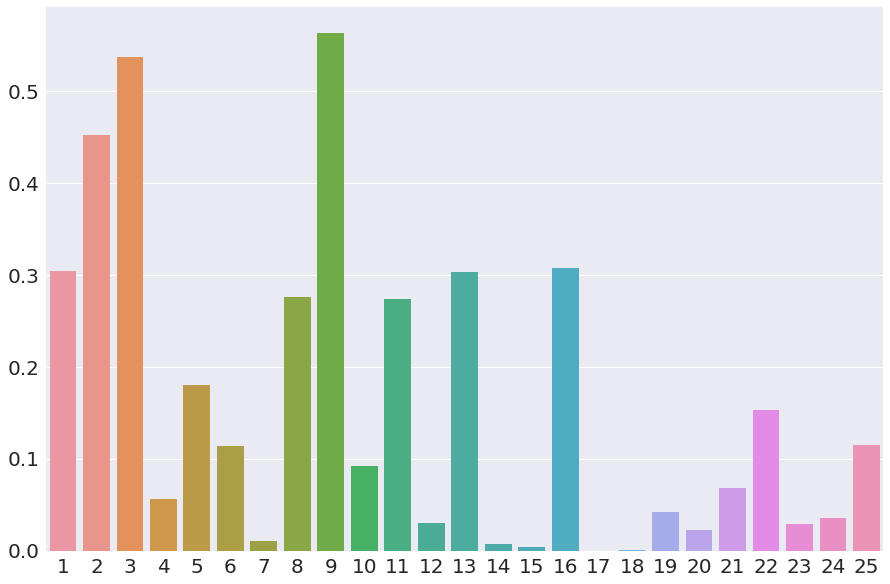

In [35]:
plt.figure(figsize=(15,10))
sns.barplot(list(f_scores.keys()), list(f_scores.values()))

In [137]:
def find_best_pair(X, y):
    res = list()
    for p in itertools.combinations(X.columns.values, 2):
        p = list(p)
        
        if any(f_scores[v] > 0.25 for v in p):
            continue

        X_curr = X[p]
        score = np.mean(cross_val_score(Pipeline([('n', Normalizer()), ('lr', LogisticRegression())]),
                                        X_curr, y, cv=5, scoring='accuracy'))
        
        res.append((p, score))
    
    return sorted(res, key=lambda x:x[1], reverse=True)      

In [138]:
pair_scores = find_best_pair(X, y)

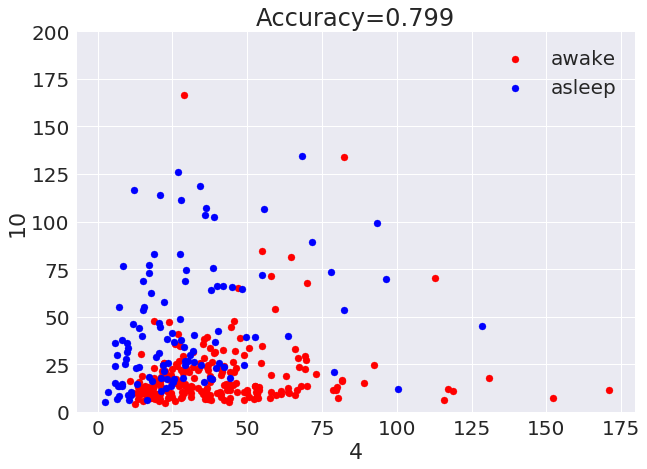

In [149]:
y_awake = np.where(y == 1)
y_asleep = np.where(y == 0)

for p, s in pair_scores[:1]:   
    X_curr = X[p]
    
    X_curr_awake = X_curr.iloc[y_awake].as_matrix()
    X_curr_asleep = X_curr.iloc[y_asleep].as_matrix()
    
    model = LogisticRegression()
    model.fit(X_curr, y)
    
    a, b = model.coef_[0][0], model.coef_[0][1]
    
    plt.figure(figsize=(10, 7))
    plt.scatter(X_curr_awake[:, 0], X_curr_awake[:, 1], color='red', label='awake')
    plt.scatter(X_curr_asleep[:, 0], X_curr_asleep[:, 1], color='blue', label='asleep')
    
    plt.xlabel(p[0])
    plt.ylabel(p[1])
    plt.ylim([0, 200])
    plt.title('Accuracy={}'.format(round(s, 3)))
    plt.legend()

In [154]:
trials = Trials()
best_params_pat = optimize(X, y, patients, trials, cv_type='patient', model_type='rf')

HBox(children=(IntProgress(value=0, max=250), HTML(value='')))

In [155]:
trials = Trials()
best_params_simple = optimize(X, y, patients, trials, model_type='rf', cv_type='simple')

HBox(children=(IntProgress(value=0, max=250), HTML(value='')))

(0.0, 1.0)

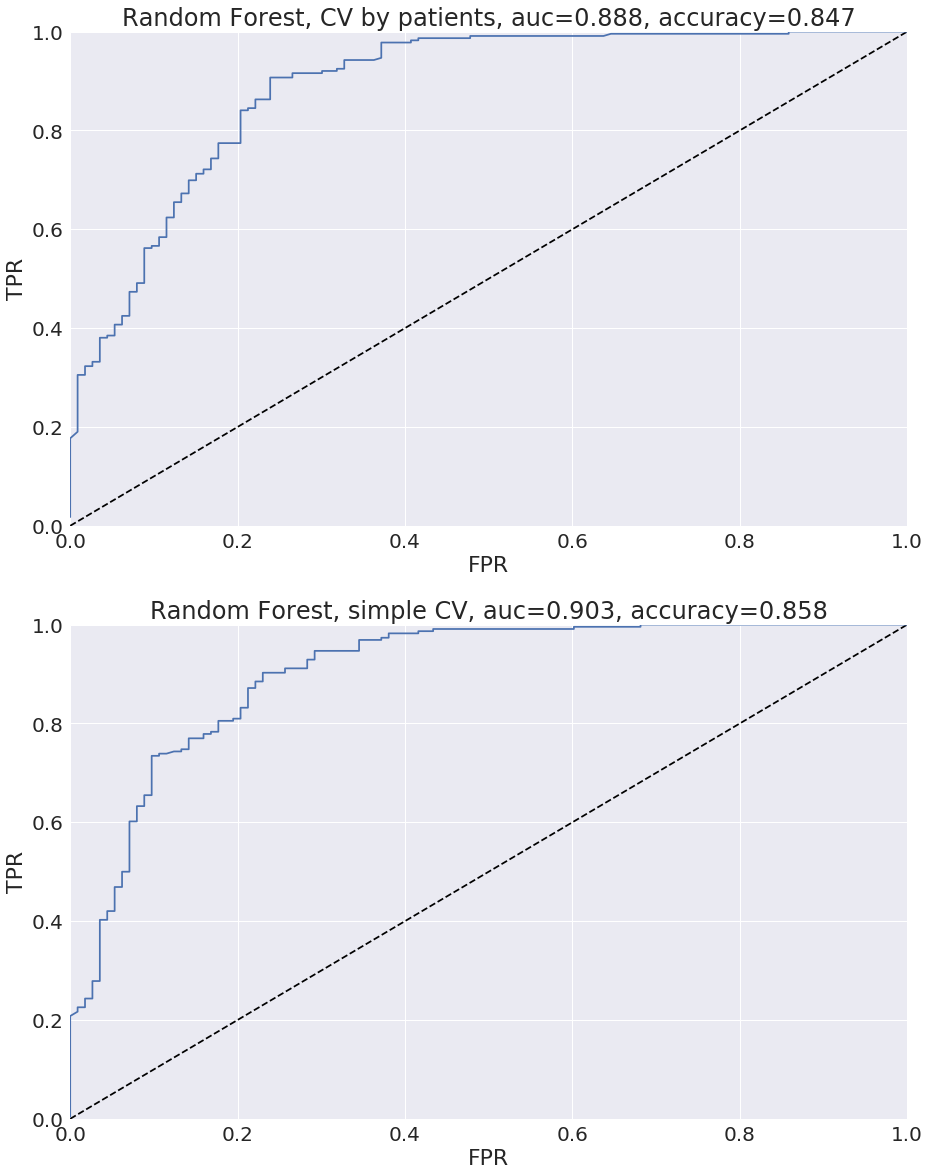

In [157]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,20))

st_acc, st_auc = patient_cv(X, y, patients, 'rf', best_params_pat, ax=ax1)
burst_acc, burst_auc = simple_cv(X, y, patients, 'rf', best_params_simple, ax=ax2)

ax1.set_title('Random Forest, CV by patients, auc={}, accuracy={}'.format(round(st_auc, 3), round(st_acc, 3)))
ax2.set_title('Random Forest, simple CV, auc={}, accuracy={}'.format(round(burst_auc, 3), round(burst_acc, 3)))
# ax3.set_title('Random Forest, all features, auc={}, accuracy={}'.format(round(all_auc, 3), round(all_acc, 3)))

ax1.set_xlim([0., 1.])
ax1.set_ylim([0., 1.])
ax2.set_xlim([0., 1.])
ax2.set_ylim([0., 1.])

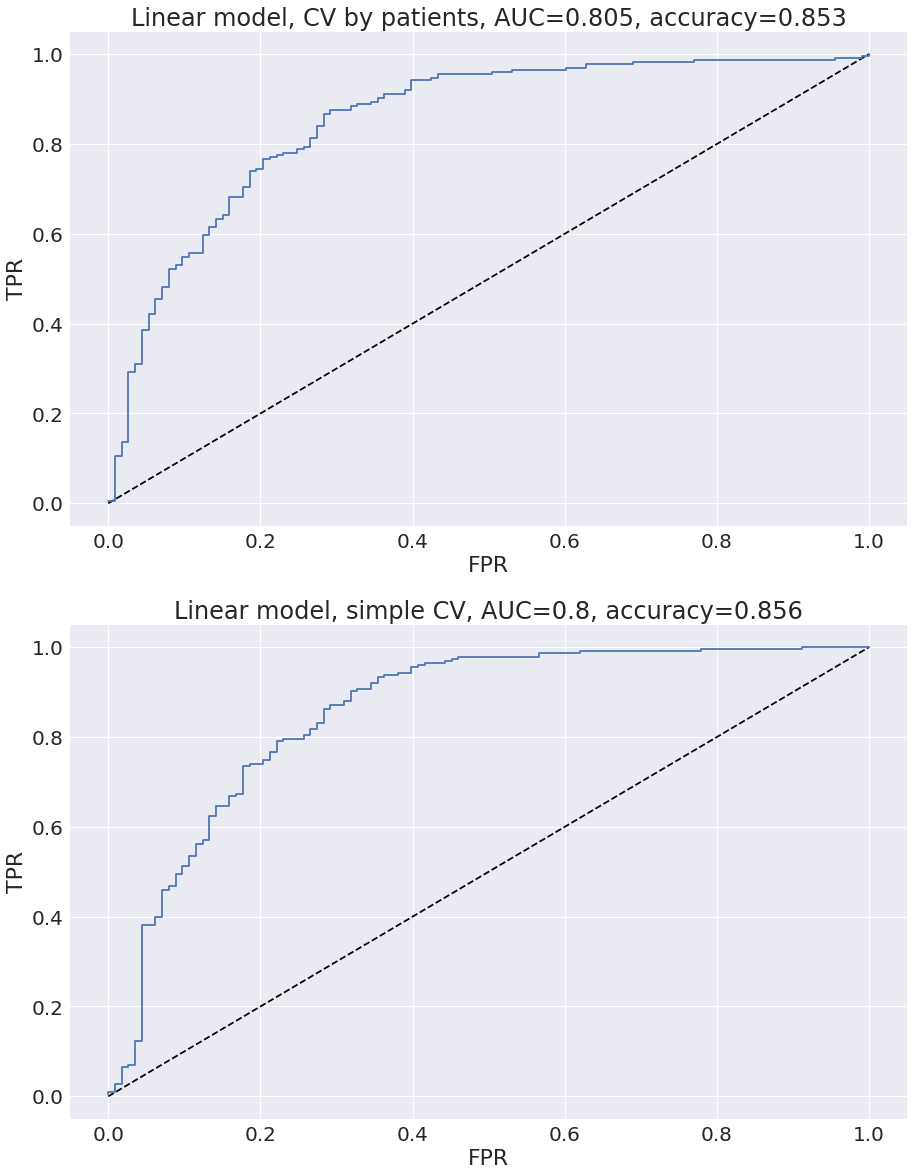

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,20))

acc, auc_score = patient_cv(X, y, patients, 'linear', None, ax=ax1)
ax1.set_title('Linear model, CV by patients, AUC={}, accuracy={}'.format(round(acc, 3), round(auc_score, 3)))

acc, auc_score = simple_cv(X, y, patients, 'linear', None, ax=ax2)
ax2.set_title('Linear model, simple CV, AUC={}, accuracy={}'.format(round(acc, 3), round(auc_score, 3)))

In [86]:
data.to_csv('without_burst_oscore.csv', index=False)

In [147]:
for c, idx in zip(old_cols, data.columns.values):
    print('X{} : {}'.format(idx, c))

X1 : AI
X2 : burst_spike_percent
X3 : cv
X4 : firing_rate
X5 : frequency_variance
X6 : isi_mean
X7 : isi_median
X8 : isi_std
X9 : isi_larger_than_mean
X10 : kurtoisis
X11 : skewness
X12 : lv
X13 : nu
X14 : oscore_12.0_20.0
X15 : oscore_20.0_30.0
X16 : oscore_3.0_8.0
X17 : oscore_30.0_60.0
X18 : oscore_60.0_90.0
X19 : oscore_8.0_12.0
X20 : interburst_interval
X21 : mean_isi_in_burst
X22 : median_isi_in_burst
X23 : mean_spikes_in_burst
X24 : burst_oscore_12.0_20.0
X25 : burst_oscore_20.0_30.0
X26 : burst_oscore_3.0_8.0
X27 : burst_oscore_30.0_60.0
X28 : burst_oscore_60.0_90.0
X29 : burst_oscore_8.0_12.0
X30 : burst_index
X31 : pause_index
X32 : modalirity_burst
X33 : bi_2
X34 : burst_behaviour
X35 : pause_ratio
X36 : awake


In [48]:
data.groupby(26).median().transpose()

26,0,1
1,0.433769,0.634081
2,0.578041,0.285714
3,1.967190,1.091212
4,24.704916,35.899690
5,67.597765,50.458844
6,0.040627,0.027942
7,0.014297,0.017645
8,0.081705,0.033569
9,0.210280,0.328058
10,35.917392,13.535404


In [109]:
corr_diff = awake_corr - sleep_corr
big_diff = np.where(corr_diff.abs() < 0.1)

In [117]:
print('{0:20} {1:20} {2:10} {3:10}'.format('F1', 'F2', 'sleep corr', 'awake corr'))
print('*'*63)

for l, r in zip(big_diff[0], big_diff[1]):
    sc = round(sleep_corr[l+1][r+1], 4)
    ac = round(awake_corr[l+1][r+1], 4)
    
    if abs(ac) > 0.75 and ac != 1.0:        
        print('{0:20} {1:20} {2:10} {3:10}'.format(old_cols[l], old_cols[r], sc, ac))


F1                   F2                   sleep corr awake corr
***************************************************************
AI                   burst_spike_percent     -0.9358    -0.8788
AI                   cv                      -0.7893    -0.8577
AI                   isi_larger_than_mean     0.8516     0.8324
burst_spike_percent  AI                      -0.9358    -0.8788
burst_spike_percent  cv                       0.8255     0.8093
cv                   AI                      -0.7893    -0.8577
cv                   burst_spike_percent      0.8255     0.8093
cv                   isi_larger_than_mean    -0.8531    -0.8454
isi_mean             isi_median               0.8106     0.8824
isi_median           isi_mean                 0.8106     0.8824
isi_larger_than_mean AI                       0.8516     0.8324
isi_larger_than_mean cv                      -0.8531    -0.8454
kurtoisis            skewness                 0.9437     0.9148
skewness             kurtoisis          